In [2]:
# 패키지 불러오기
require(ggplot2)
require(repr)
options(repr.plot.width=10, repr.plot.height=3)

Loading required package: ggplot2
Loading required package: repr


In [3]:
# 삭제
rm(list = ls())

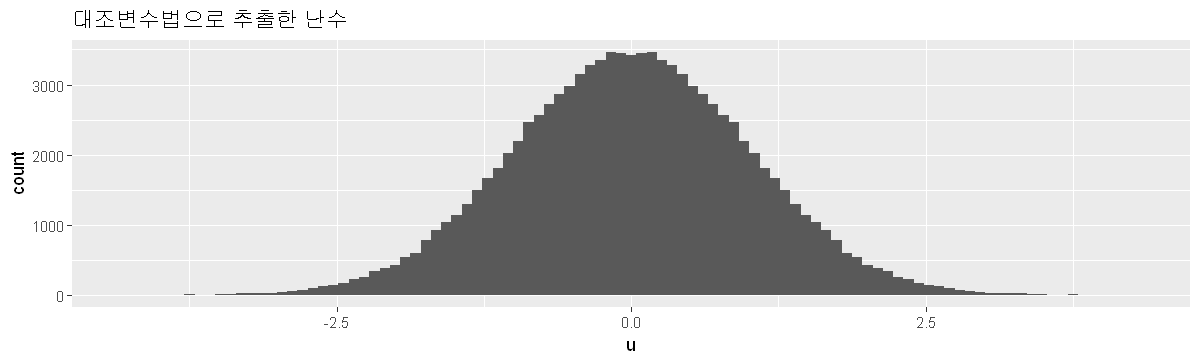

In [4]:
# 대조변수법
Antithetic.rand <- function(scens, vars=1){
    isodd = scens%%2
    num = scens%/%2 + isodd
    z <- matrix(rnorm(num*vars, mean=0, sd=1), num, vars)
    value <- rbind(z,-z)
    if(isodd == TRUE) value <- value[-1,]
    return(scale(value))
}
    
u <- Antithetic.rand(100000)
ggplot() +
    geom_histogram(aes(x=u), bins=100) +
    labs(title='대조변수법으로 추출한 난수')

In [106]:
## Term Structure Class 정의

# Smith-Wilson Class
setClass('Smith.Wilson',
        representation(alpha="numeric", UFR="numeric", terms="numeric", int="numeric", zeta="numeric"))

# Wilson function
setGeneric("Wilson", function(object, ...) standardGeneric("Wilson"))
setMethod("Wilson", "Smith.Wilson", Vectorize(function(object,t,u,order=0){
    if (order==0) {
        y <- exp(-object@UFR*(t+u))*(object@alpha*pmin(t,u) - 0.5*exp(-object@alpha*pmax(t,u))*(exp(object@alpha*pmin(t,u)) - exp(-object@alpha*pmin(t,u))))
    }else if(order==1){
        if (t < u) y <- exp(-object@UFR*t-(object@alpha+object@UFR)*u)*(object@UFR*sinh(object@alpha*t)-object@alpha*cosh(object@alpha*t)-object@alpha*(object@UFR*t-1)*exp(object@alpha*u))
        else y <- exp(-object@UFR*u-(object@alpha+object@UFR)*t)*((object@alpha+object@UFR)*sinh(object@alpha*u)-object@alpha*object@UFR*u*exp(object@alpha*t))
    }else if(order==2){
        if (t < u) y <- exp(-object@UFR*t-(object@alpha+object@UFR)*u)*(-(object@alpha^2+object@UFR^2)*sinh(object@alpha*t)+2*object@alpha*object@UFR*cosh(object@alpha*t)+object@alpha*object@UFR*(object@UFR*t-2)*exp(object@alpha*u)) 
        else y <- exp(-object@UFR*u-(object@alpha+object@UFR)*t)*(object@alpha*object@UFR^2*u*exp(object@alpha*t)-(object@alpha+object@UFR)^2*sinh(object@alpha*u))
    }else print('유효한 order가 아닙니다.')
    return(y)
}, vectorize.args=c('t','u')))
         
# Term Structure
setGeneric("TermStr", function(object, ...) standardGeneric("TermStr"))
setMethod("TermStr", "Smith.Wilson", function(object, t){
    y <- (1/Bond(object,t))^(1/t) - 1
    return(y)
})

# Forward Rate
setGeneric("Forward", function(object, ...) standardGeneric("Forward"))
setMethod("Forward", "Smith.Wilson", Vectorize(function(object, t, order=0){
    if (order==0) y <- -Bond(object,t,1)/Bond(object,t,0)
    else if (order==1) y <- 1/Bond(object,t,0)*(-Bond(object,t,1)^2/Bond(object,t,0) + Bond(object,t,2))
    else print('유효한 order가 아닙니다.')
    return(y)
}, vectorize.args='t'))
        
# Bond Price
setGeneric("Bond", function(object, ...) standardGeneric("Bond"))
setMethod("Bond", "Smith.Wilson", Vectorize(function(object, t, order=0){
    y <- (-object@UFR)^order*exp(-object@UFR*t) + object@zeta %*% Wilson(object, t, object@terms, order)
    return(y)
}, vectorize.args="t"))

# Initialize
setMethod("initialize", "Smith.Wilson", function(.Object, alpha, UFR, terms, int){
    .Object@alpha <- alpha
    .Object@UFR <- UFR
    .Object@terms <- terms
    .Object@int <- int
    
    W <- outer(terms, terms, FUN=function(x,y) Wilson(.Object, x, y))
    m  <- 1/(1+int)^terms
    mu <- exp(-UFR*terms)
    .Object@zeta <- as.numeric((m-mu)%*%solve(W))
    
    return(.Object)
})

[1] "Wilson"

[1] "Wilson"

[1] "TermStr"

[1] "TermStr"

[1] "Forward"

[1] "Forward"

[1] "Bond"

[1] "Bond"

[1] "initialize"

In [60]:
# 입력 데이터
int.rate <- c(0.0334,0.0326,0.0327,0.0328,0.033,0.0335,0.0342,0.0345,0.0347,0.0352)
int.mat <- c(1,2,3,4,5,7,10,12,15,20)
vol <- matrix (c(0.1815,0.172,0.17,0.1605,0.158,0.155,
                 0.177,0.1715,0.17,0.158,0.1545,0.15,
                 0.174,0.168,0.1655,0.1555,0.1495,0.1475,
                 0.165,0.1575,0.157,0.1495,0.1455,0.144,
                 0.165,0.1575,0.157,0.1535,0.1455,0.144,
                 0.1665,0.159,0.1575,0.15,0.1455,0.14),
                 ncol=6, byrow=TRUE)
colnames(vol) <- rownames(vol) <- tenor <- c(1,2,3,5,7,10)
N <- 100

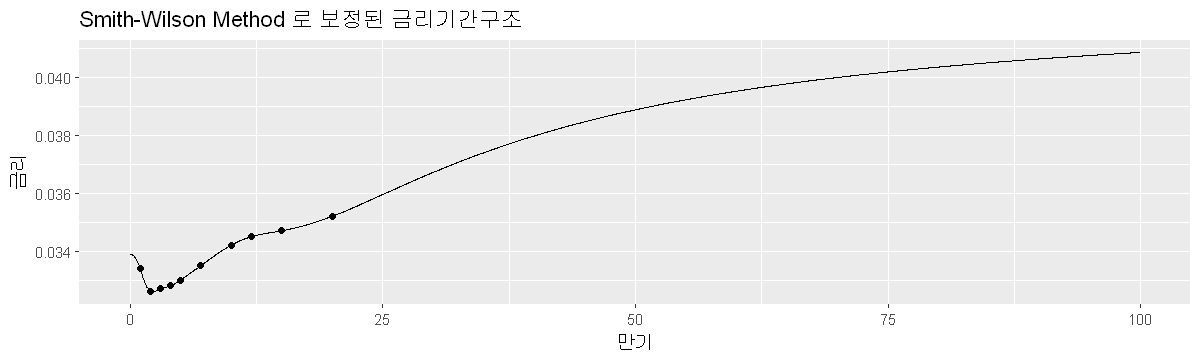

In [61]:
# Smith-Wilson 객체 생성
sw <- new("Smith.Wilson", alpha=0.1, UFR=0.042, terms=int.mat, int=int.rate)

# 보정된 금리 생성
t <- seq(0.01,100,by=0.05)
int.rate.sw <- TermStr(sw, t)
    
# 그래프 출력
ggplot() +
    geom_line(aes(x=t, y=int.rate.sw)) +
    geom_point(aes(x=int.mat, y=int.rate)) +
    labs(x='만기', y='금리', title='Smith-Wilson Method 로 보정된 금리기간구조')

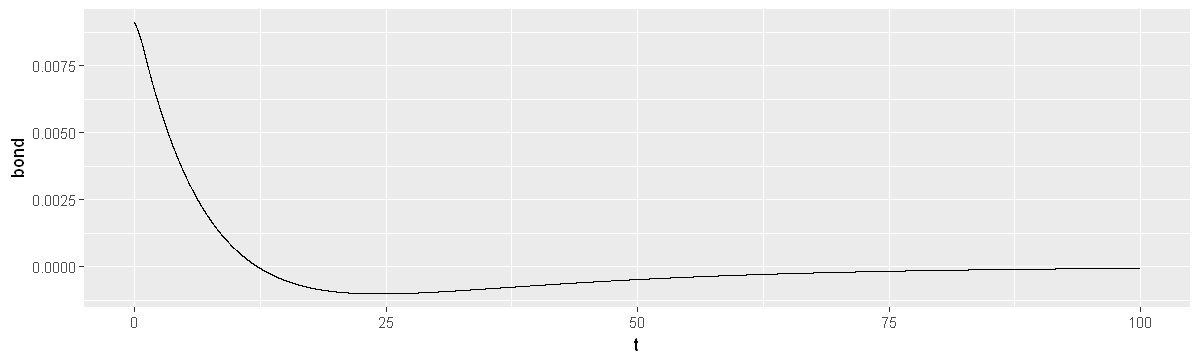

In [116]:
# 보정된 금리 생성
t <- seq(0.01,100,by=0.01)
bond <- Wilson(sw, t,1,order=1)
    
# 그래프 출력
ggplot() +
    geom_line(aes(x=t, y=bond))

[1] "Forward Rate at 100 Year is... 4.2%"


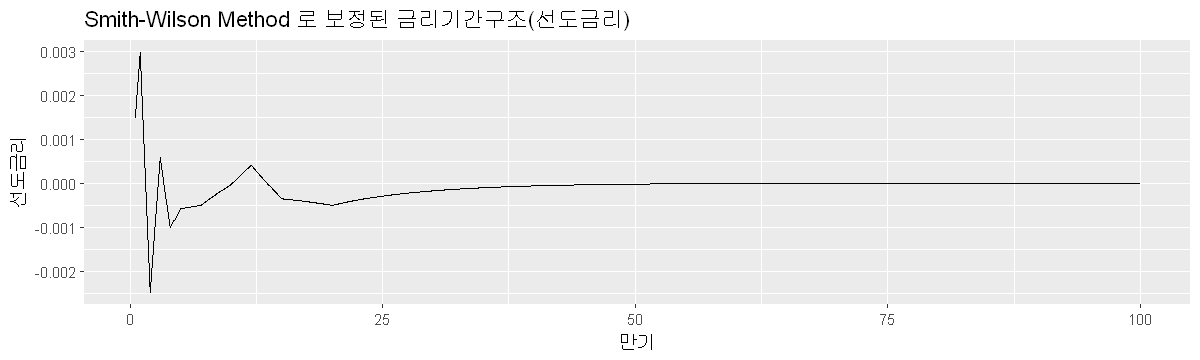

In [131]:
# 보정된 금리 생성
t <- seq(0.5,100,by=0.05)
price <- Forward(sw, t, 1)
    
# 그래프 출력
ggplot() +
    geom_line(aes(x=t, y=price)) +
    labs(x='만기', y='선도금리', title='Smith-Wilson Method 로 보정된 금리기간구조(선도금리)')
print(paste0('Forward Rate at 100 Year is... ', round(Forward(sw, 100)*100,3),'%'))

In [64]:
# Black Swaption
price.alpha <- outer(tenor, tenor, FUN=function(x,y) Bond(sw, x))
price.beta <- outer(tenor, tenor, FUN=function(x,y) Bond(sw, x+y))
d1 <- 0.5*vol*sqrt(tenor)
rs.blk <- N*(price.alpha - price.beta)*(2*pnorm(d1, mean=0, sd=1)-1)
rs.blk

,1,2,3,5,7,10
1,0.2156563,0.4091251,0.6014401,0.9328942,1.265111,1.718248
2,0.2975359,0.5691316,0.8391249,1.2795903,1.719499,2.299471
3,0.3484518,0.6689291,0.9818963,1.5127983,1.993963,2.695706
5,0.4146125,0.7847689,1.1619576,1.8017969,2.384505,3.206093
7,0.4707874,0.8881613,1.3094864,2.0657912,2.643937,3.558126
10,0.5168802,0.9684608,1.4090658,2.1546571,2.837103,3.745406


In [138]:
# Hull-White Class 정의
setClass('Hull.White',
        representation(alpha="numeric", sigma="numeric", termStr='Smith.Wilson'))

# Bond Price
setMethod("Bond", "Hull.White", function(object,r,t=0,T,S){
    y <- A(object,r,t,T,S)*exp(-B(object,t,T)*r)
    return(y)
})
    
# Volatility
setGeneric("Vol", function(object, ...) standardGeneric("Vol"))
setMethod("Vol", "Hull.White", function(object,t,T,S){
    y <- (exp(-object@alpha*T) - exp(-object@alpha*S))^2/(2*object@alpha^3)*object@sigma^2*(exp(2*object@alpha*T)-1)
    return(y)
})
    
# A(t,T)
setGeneric("A", function(object, ...) standardGeneric("A"))
setMethod("A", "Hull.White", function(object,r,t,T,S){
    y <- Bond(object@termStr,T)/Bond(object@termStr,t)*exp(-B(object,t,T)*(r-Forward(object@termStr, t))- 0.5*Vol(object,t,T,S))
    return(y)
})
    
# B(t,T)
setGeneric("B", function(object, ...) standardGeneric("B"))
setMethod("B", "Hull.White", function(object,t,T,S){
    y <- (1-exp(-object@alpha*(T-t)))/object@alpha
    return(y)
})

# 객체 초기화
setMethod("initialize", "Hull.White", function(.Object, alpha, sigma, termStr){
    .Object@alpha <- alpha
    .Object@sigma <- sigma
    .Object@termStr <- termStr
    
    return(.Object)
})

[1] "Bond"

[1] "Vol"

[1] "Vol"

[1] "A"

[1] "A"

[1] "B"

[1] "B"

[1] "initialize"

In [120]:
hw <- new("Hull.White", alpha=0.05, sigma=0.006, termStr=sw)

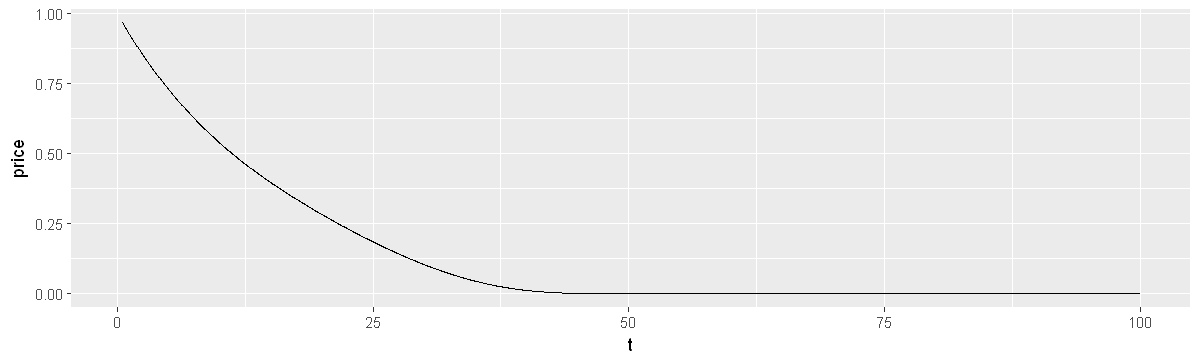

In [139]:
price <- Bond(hw,r=0.034,T=t,S=2)

# 그래프 출력
ggplot() +
    geom_line(aes(x=t, y=price))

In [ ]:
# Forward Swap Rate
tau <- 0.25
fswap <- Vectorize(function(x,y) (Bond(sw, x)- Bond(sw, x+y))/(tau*sum(Bond(sw, seq(x+tau,x+y,tau)))), vectorize.args = c('x','y'))
fswap.rate <- outer(tenor, tenor, fswap)

In [ ]:
rs.hw <- Vectorize(function(T,S) {
i <- seq(T+tau,T+S,tau)

tau <- 0.25
N <- 100

error <- function(r){
c <- rep(fswap(T,S)*tau,S/tau)
c[S/tau] <- 1+c[S/tau]
return(abs(sum(c*Bond(hw, r=r, t=T, T=i, S=S))-1))
}
r <- optimize(error, interval=c(0,1))$minimum
X <- Bond(hw, r=r, t=T, T=i, S=S)
di.pos <- 1/Vol(hw, t=0,T=T,S=i)*log(Bond(hw, r=r,t=0,T=i,S=S)/Bond(hw, r=r,t=0,T=T,S=S)/X) + Vol(hw,t=0,T=T,S=i)/2
di.neg <- di.pos - Vol(hw,t=0,T=T,S=i)

y <- N*sum(c*(Bond(hw,r=r,t=0,T=i,S=S)*dnorm(di.pos) - X*Bond(hw,r=r,t=0,T=T,S=S)*dnorm(di.neg)))

return(y) 
}, vectorize.args = c('T','S'))

mse <- sum(((rs.blk - outer(tenor, tenor, rs.hw))/rs.blk)^2)